In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve 

from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler


In [3]:
pd.set_option("display.max_columns", 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Importing data

In [4]:
df = pd.read_csv('Bikesharingdata.csv')

In [5]:
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.111,18.181,80.583,10.750,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.903,17.687,69.609,16.652,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.051,9.470,43.727,16.637,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200,10.606,59.044,10.740,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305,11.463,43.696,12.522,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.421,11.332,65.292,23.459,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.387,12.752,59.000,10.417,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.387,12.120,75.292,8.334,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489,11.585,48.333,23.501,364,1432,1796


To keep the raw data for later residuals analysis, we will keep a raw copy of the data, included the time-series column 'dteday':

In [6]:
raw = df.copy()

# 1. Exploratory Data Analysis 

The dataset have the following fields:
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

Each features need further exploration and some need encoding. Let's go deep into each field!

#### Overall information

Here is the first few columns of the dataset:

In [7]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.111,18.181,80.583,10.750,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.903,17.687,69.609,16.652,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.051,9.470,43.727,16.637,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200,10.606,59.044,10.740,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305,11.463,43.696,12.522,82,1518,1600


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


Some further actions need to do before putting data to model:
- instant: drop this columns as there are no meaning to the model
- casual, registered: drop these columns as 'cnt' is a sum of these two columns
- dteday: drop this column as we have all columns represent year, month, weekday in the dataset already
- season, yr, mnth, weekday, weathersit: encoding to dummy variables
- temp, atemp, hum, windspeed, casual, registered: scaling
- cnt: change name to 'label'

In [9]:
# Drop unnecessary column
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis = 1)

In [10]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

Let's mapping back the categorical values of each column:

In [11]:
# Change the name of values in columns that will be encoded
df['season'] = df['season'].replace({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
df['yr'] = df['yr'].replace({0:'2018', 1:'2019'})
df['weekday'] = df['weekday'].replace({0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thur', 4:'Fri', 5:'Sat', 6:'Sun'})
df['weathersit'] = df['weathersit'].replace({1:'Clear', 2:'Mist', 3:'Lightsnow', 4:'Heavyrain'})

In [12]:
# Change name of the column 'cnt' 
df = df.rename(columns = {'cnt' :'label'})

## Univariate - Bivariate - Multivariate Analysis

#### Outliers Checking

In [13]:
df.describe(percentiles= (0.1,0.25,0.5,0.75, 0.85, 0.95, 0.99))

,mnth,holiday,workingday,temp,atemp,hum,windspeed,label
count,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000
mean,6.526,0.029,0.684,20.319,23.726,62.765,12.764,4508.007
std,3.450,0.167,0.465,7.507,8.150,14.238,5.196,1936.012
min,1.000,0.000,0.000,2.424,3.953,0.000,1.500,22.000
10%,2.000,0.000,0.000,10.653,12.752,45.000,6.705,1742.600
25%,4.000,0.000,0.000,13.812,16.890,52.000,9.042,3169.750
50%,7.000,0.000,1.000,20.466,24.368,62.625,12.125,4548.500
75%,10.000,0.000,1.000,26.881,30.446,72.990,15.626,5966.000
85%,11.000,0.000,1.000,29.144,32.735,77.569,18.129,6856.300
95%,12.000,0.000,1.000,31.520,35.750,86.869,23.000,7576.400


Apart from 'hum' and 'windspeed', all other numerical variables is having a good distrubution with no clear outliers:

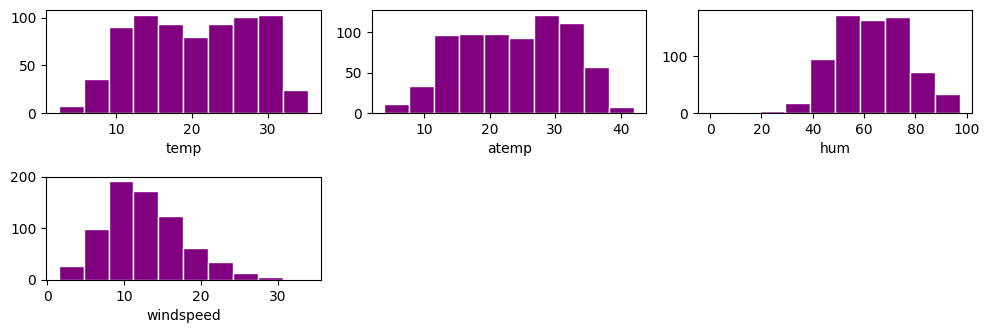

In [14]:
plt.figure(figsize = (10,8))

n = 1
columns = ['temp', 'atemp', 'hum', 'windspeed']
for i in columns:
    if n<=len(columns):
        plt.subplot(5, 3, n)
        plt.hist(x=i, data = df, color = 'purple', edgecolor = 'white')
        plt.xlabel(i)
        plt.tight_layout()
        n+=1
    else:
        break
plt.show()

Let's see the data points that are out of inner quantile clearer through the boxplots:

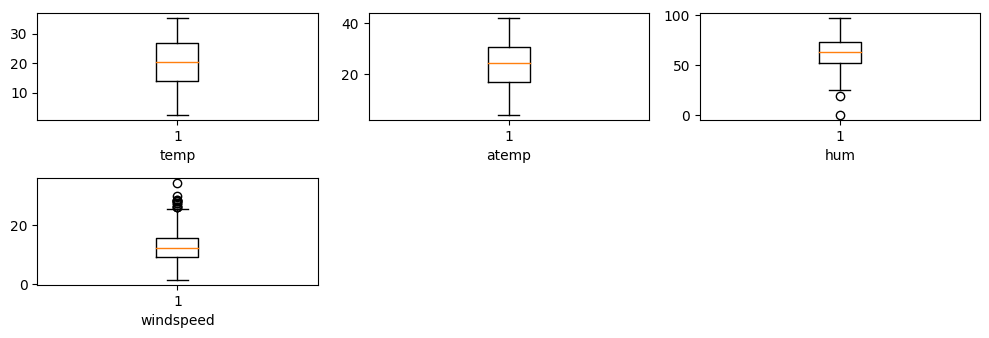

In [15]:
plt.figure(figsize = (10,8))

n = 1
columns = ['temp', 'atemp', 'hum', 'windspeed']
for i in columns:
    if n<=len(columns):
        plt.subplot(5, 3, n)
        plt.boxplot(x=i, data = df)
        plt.xlabel(i)
        plt.tight_layout()
        n+=1
    else:
        break
plt.show()

However, in reality, windspeed and humidity could be outliers in some particular days of the years. So that, there are no need to remove those records that have values out of inner quantile for 'windspeed' and 'hum'.

#### Overall trend

Let's create scatterplots to see the trends in the columns values compared to the 'cnt' (label) column:

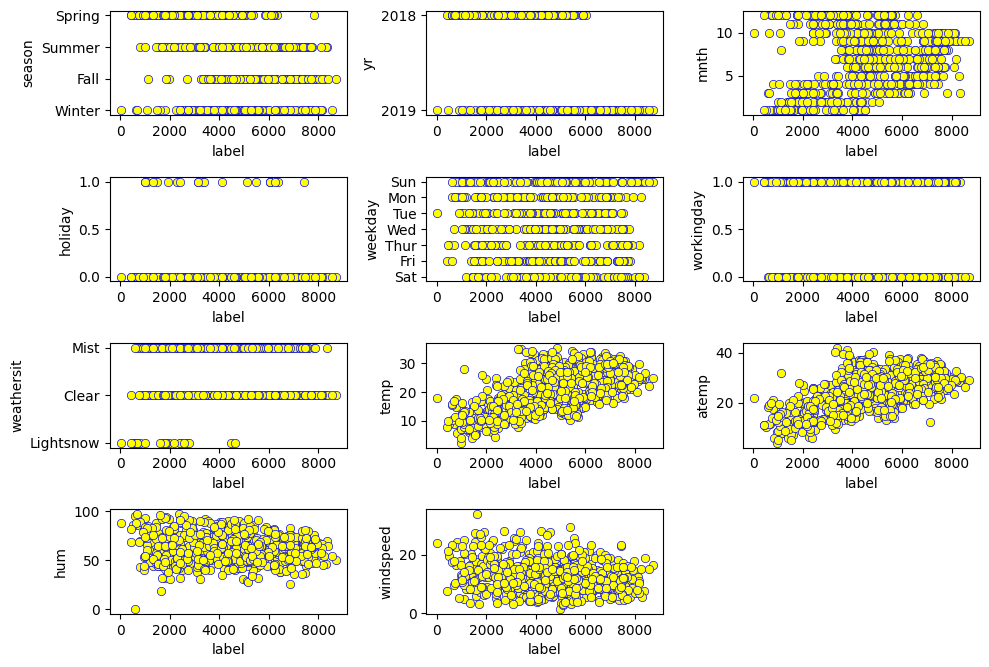

In [1055]:
plt.figure(figsize = (10,8))

n = 1
columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
for i in columns:
    if n<=len(columns):
        plt.subplot(5, 3, n)
        sns.scatterplot(x='label', y= i, data = df, color = 'yellow', edgecolor = 'blue')
        plt.tight_layout()
        n+=1
    else:
        break
plt.show()

From the plots, we could see some insights:
- Spring has less demand than the rest of season
- 2019 has bigger demand
- Months between May and October have bigger demand compared to the rest of the year
- Day of the week and Working day do not have any clear distinct trends in demand
- Light snow weather has lowest demand
- temp and atemp has a linear relationship with demand
- hum and windspeed do not have any clear linear relationship with demand

#### Dummy columns created

Let's create dummy variables, all of values in columns are able to use drop_first argument:

In [1056]:
# Create dummy variables and dropping first column
for i in ['season', 'yr','weekday', 'weathersit', 'mnth'] :
    dummy = pd.get_dummies(df[i], drop_first= True, dtype = 'int', prefix = i)
    df = pd.concat([df,dummy], axis = 1)
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'label',
       'season_Spring', 'season_Summer', 'season_Winter', 'yr_2019',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thur',
       'weekday_Tue', 'weekday_Wed', 'weathersit_Lightsnow', 'weathersit_Mist',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')

In [1057]:
# Drop unnecessary columns
df = df.drop(['season', 'yr','weekday', 'weathersit', 'mnth'], axis = 1)

#### Test the correlation

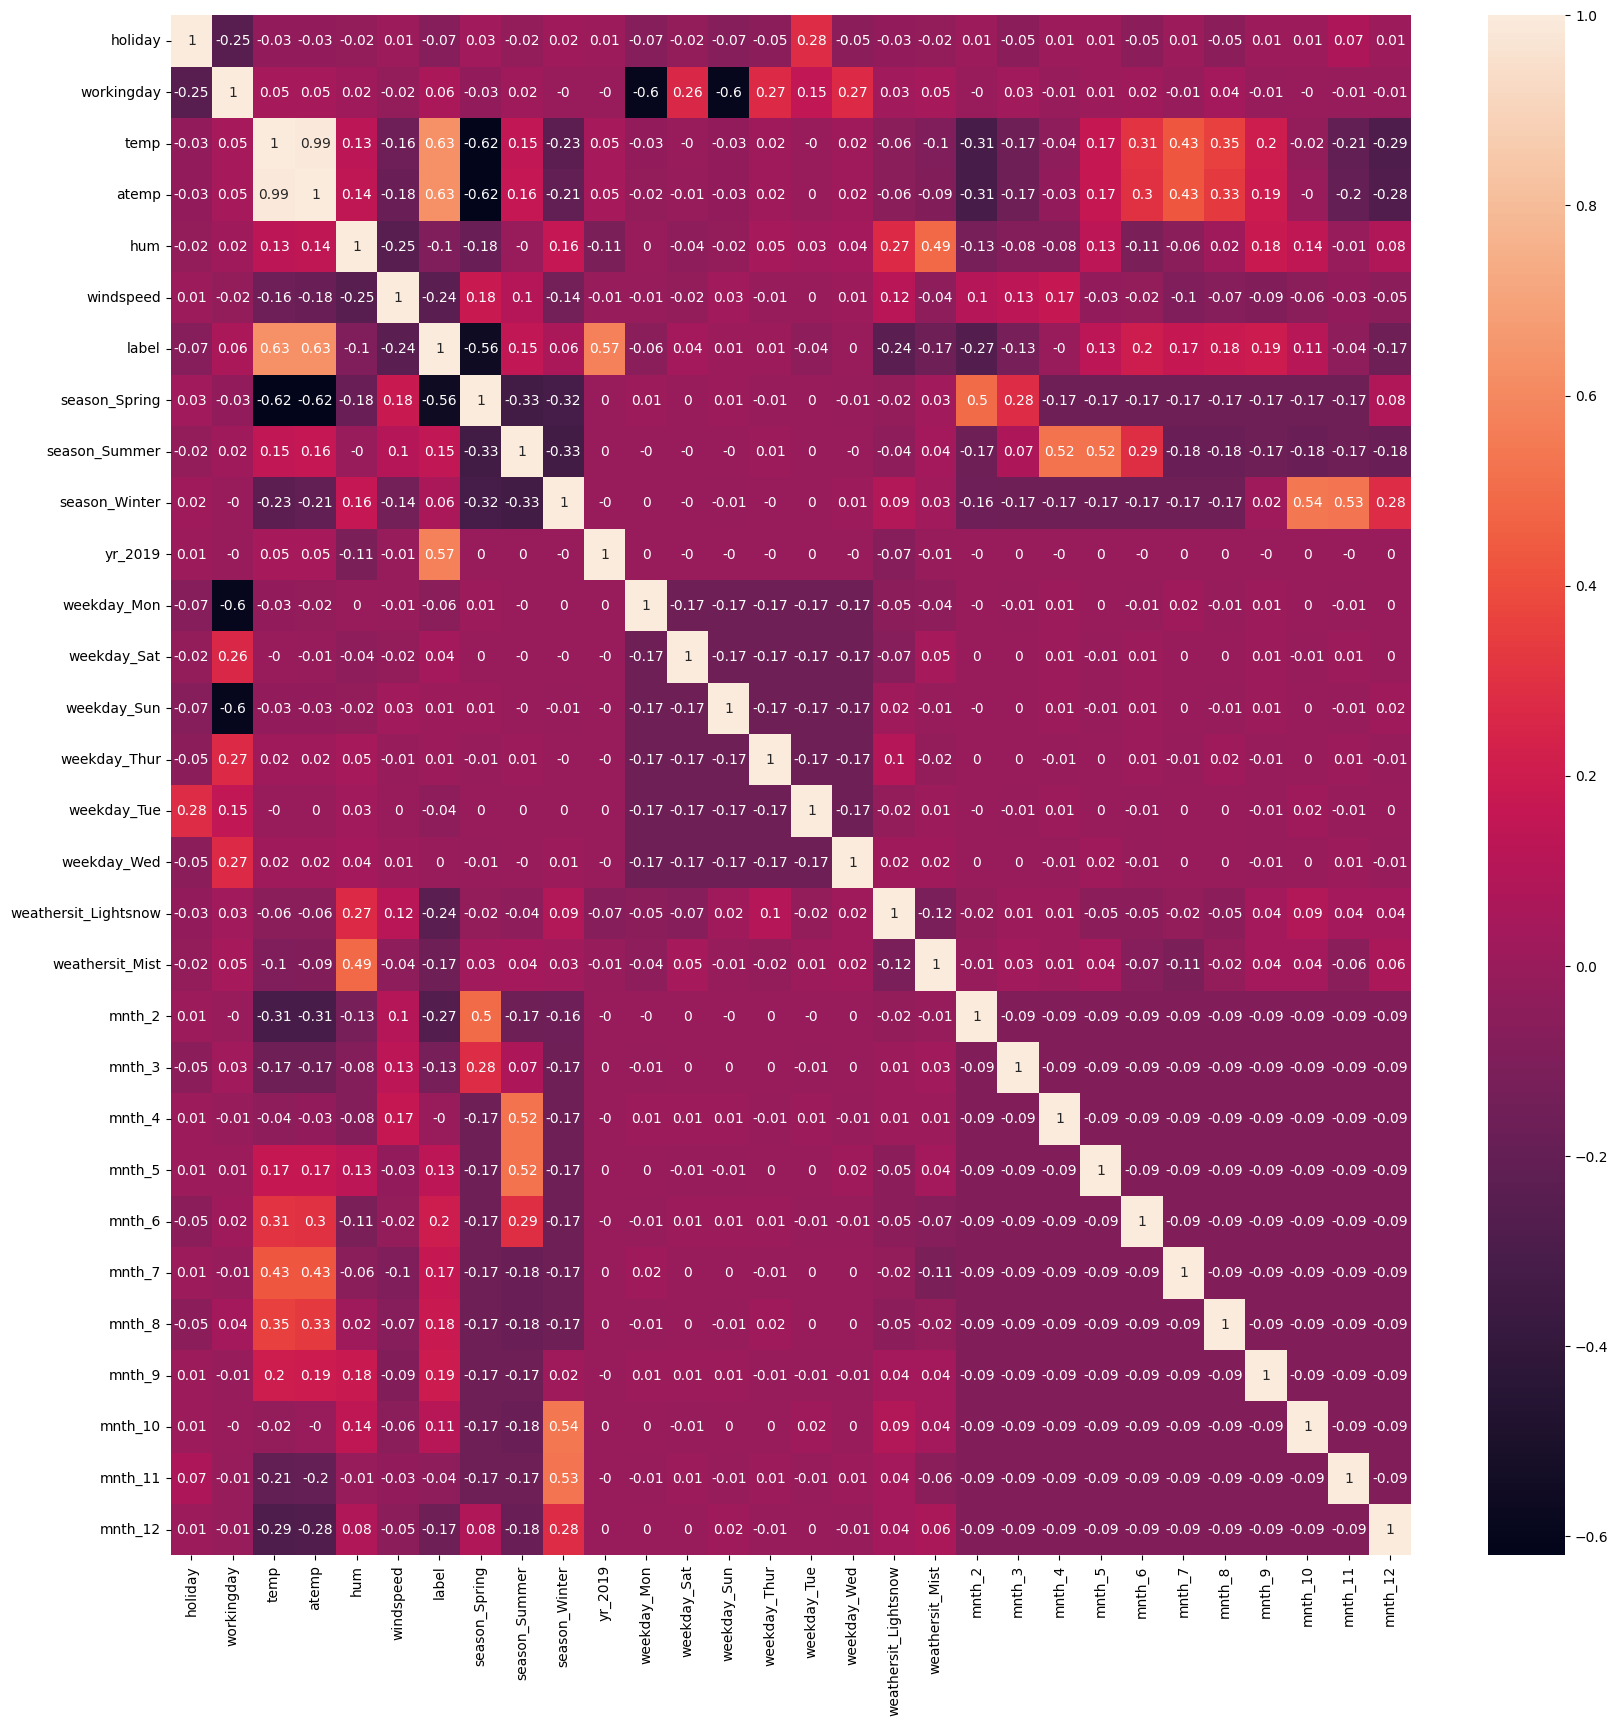

In [1058]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr().round(2), annot = True)
plt.show()

From the heatmap with annotations, we could see that column 'temp' and 'atemp' is correlated (0.99) and we could see that there are some abnormal data points of 'atemp' vs 'label' in the above charts. So, there is a need to remove 'atemp' column.

In [1059]:
df = df.drop('atemp', axis = 1)

The final dataset has 730 rows and 29 columns:

In [1060]:
df.shape

(730, 29)

These columns are:

In [1061]:
df.columns

Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'label',
       'season_Spring', 'season_Summer', 'season_Winter', 'yr_2019',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thur',
       'weekday_Tue', 'weekday_Wed', 'weathersit_Lightsnow', 'weathersit_Mist',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')

# Training the first model - Multiple Linear Regression 

We will use **Multiple Linear Regression** model:

**Multiple linear regression** is a statistical technique to understand the relationship between one dependent variable and several independent variables. The objective of multiple regression is to find a linear equation that can best determine the value of dependent variable Y for different values independent variables in X. 

After doing the EDA, let's train our first model.

#### Split train test

In [1062]:
# Split dependent and independent variables
y = df['label']
X = df.drop('label', axis = 1)

In [1063]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 1)

Because our label have only 2 unique values (0.1) so there is no need to scale this column. We only scale numeric columns below:

In [1064]:
# Scaling columns
scaler = MinMaxScaler()
# Specify column to scale
num_vars = ['temp', 'hum', 'windspeed']
# Train the scaler on train set and transform the train dataset
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

Let's check our train dataset after scaling:

In [1065]:
X_train.describe()

,holiday,workingday,temp,hum,windspeed,season_Spring,season_Summer,season_Winter,yr_2019,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thur,weekday_Tue,weekday_Wed,weathersit_Lightsnow,weathersit_Mist,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
count,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000,511.000
mean,0.031,0.683,0.565,0.526,0.400,0.219,0.264,0.250,0.505,0.160,0.137,0.125,0.141,0.153,0.143,0.031,0.325,0.072,0.070,0.084,0.092,0.084,0.094,0.084,0.086,0.080,0.098,0.072
std,0.174,0.466,0.227,0.194,0.190,0.414,0.441,0.434,0.500,0.367,0.344,0.331,0.348,0.360,0.350,0.174,0.469,0.259,0.256,0.278,0.289,0.278,0.292,0.278,0.281,0.272,0.297,0.259
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.373,0.380,0.264,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,1.000,0.583,0.524,0.371,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,1.000,0.759,0.669,0.513,0.000,1.000,0.500,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


#### Train first model

In [1066]:
# Add constant to train dataset
X_train_sm = sm.add_constant(X_train)
# Create model
linreg = sm.OLS(y_train, X_train_sm)
# fit the model
linreg_model = linreg.fit()

In [1067]:
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     92.61
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          6.00e-172
Time:                        21:08:49   Log-Likelihood:                -4118.1
No. Observations:                 511   AIC:                             8292.
Df Residuals:                     483   BIC:                             8411.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1808.6033    284.018      6.368      0.000    1250.539    2366.667
holiday                 53.9465    192.277      0.281      0.779    -323.856     431.749
workingday             640.0065    102.043      6.272      0.000     439.503     840.510
temp                  3793.4659    411.580      9.217      0.000    2984.758    4602.174
hum                  -1289.7066    274.177     -4.704      0.000   -1828.434    -750.979
windspeed            -1381.4028    207.076     -6.671      0.000   -1788.285    -974.521
season_Spring         -655.9530    271.783     -2.414      0.016   -1189.977    -121.930
season_Summer          249.1621    231.727      1.075      0.283    -206.155     704.479
season_Winter          566.9253    233.734      2.426      0.016     107.665    1026.186
yr_2019               2038.7702     71.888     28.360      0.000    1897.518    2180.022
weekday_Mon            265.8564    116.234      2.287      0.023      37.469     494.244
weekday_Sat            -61.4703    133.309     -0.461      0.645    -323.408     200.468
weekday_Sun            848.7939    120.037      7.071      0.000     612.934    1084.654
weekday_Thur            -0.7760    132.675     -0.006      0.995    -261.468     259.916
weekday_Tue           -153.9553    132.495     -1.162      0.246    -414.293     106.383
weekday_Wed           -132.1200    132.779     -0.995      0.320    -393.015     128.775
weathersit_Lightsnow -1926.2380    245.381     -7.850      0.000   -2408.383   -1444.093
weathersit_Mist       -302.9739     98.116     -3.088      0.002    -495.760    -110.187
mnth_2                 189.0161    181.143      1.043      0.297    -166.909     544.941
mnth_3                 692.5155    224.337      3.087      0.002     251.719    1133.312
mnth_4                 346.3455    314.447      1.101      0.271    -271.508     964.199
mnth_5                 613.6980    338.446      1.813      0.070     -51.310    1278.706
mnth_6                 344.7924    353.962      0.974      0.330    -350.702    1040.287
mnth_7                 100.3126    388.369      0.258      0.796    -662.789     863.414
mnth_8                 390.5194    377.759      1.034      0.302    -351.735    1132.774
mnth_9                1094.9611    332.421      3.294      0.001     441.792    1748.131
mnth_10                739.3104    310.019      2.385      0.017     130.157    1348.463
mnth_11                161.5199    293.094      0.551      0.582    -414.377     737.417
mnth_12                115.3980    241.311      0.478      0.633    -358.751     589.547
==============================================================================
Omnibus:                       95.904   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.67

In [1068]:
# Create dataframe to put VIF values in
vif = pd.DataFrame() 
# Add data to vif dataframe
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,workingday,71.710
9,weekday_Mon,17.170
11,weekday_Sun,13.380
22,mnth_7,10.590
5,season_Spring,10.430
23,mnth_8,9.080
6,season_Summer,8.610
7,season_Winter,8.460
21,mnth_6,7.970
20,mnth_5,7.890


# The second model with RFE

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

#### RFECV

First, we will use function RFECV to find the optimal number of features:

In [1069]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step = 1, cv = 5)
selector.fit(X_train, y_train)
print(f"Optimal number of features: {selector.n_features_}")

Optimal number of features: 18


So that, the optimal number of features is 18, let see the results in plot below:

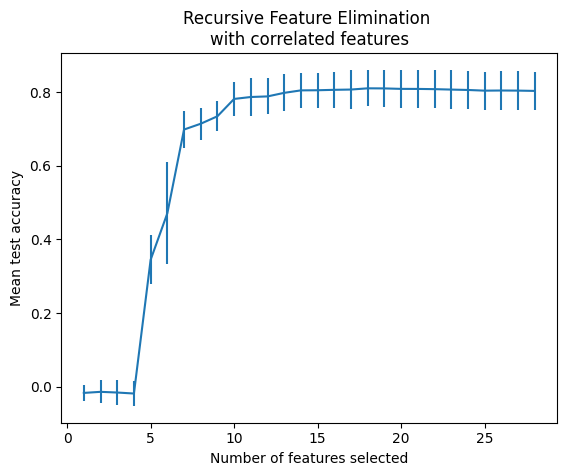

In [1070]:
min_features_to_select = 1
n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"],
    yerr=selector.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

print()

At 18 features, the mean test accuracy flattened out so that the optimal number of features is 18.

#### RFE 

Let's use the results of RFECV to find the most important variables:

In [1071]:
n_feature = selector.n_features_
n_feature

18

In [1072]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
n_feature = int(selector.n_features_)
rfe = RFE(estimator = linreg, n_features_to_select = n_feature, step = 1)
rfe = rfe.fit(X_train, y_train)

In [1073]:
rfe_columns = rfe.get_feature_names_out()
rfe_columns

array(['holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_Spring', 'season_Winter', 'yr_2019', 'weekday_Mon',
       'weekday_Sun', 'weathersit_Lightsnow', 'weathersit_Mist', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_9', 'mnth_10'], dtype=object)

So that are 18 important columns. Let's use these columns in our next model.

In [1074]:
X_train = X_train[rfe_columns]
X_train.head()

,holiday,workingday,temp,hum,windspeed,season_Spring,season_Winter,yr_2019,weekday_Mon,weekday_Sun,weathersit_Lightsnow,weathersit_Mist,mnth_3,mnth_4,mnth_5,mnth_6,mnth_9,mnth_10
589,0,1,0.838,0.405,0.272,0,0,1,0,0,0,0,0,0,0,0,0,0
135,0,1,0.656,0.743,0.249,0,0,0,0,0,0,0,0,0,1,0,0,0
626,0,1,0.624,0.393,0.460,0,0,1,0,0,0,0,0,0,0,0,1,0
554,0,1,0.825,0.597,0.378,0,0,1,0,0,0,1,0,0,0,0,0,0
311,0,1,0.442,0.651,0.111,0,1,0,0,0,0,0,0,0,0,0,0,0


In [1075]:
# Add constant to train dataset
X_train_sm = sm.add_constant(X_train)
# Create model
linreg = sm.OLS(y_train, X_train_sm)
# fit the model
linreg_model = linreg.fit()

In [1076]:
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     147.2
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          1.21e-180
Time:                        21:08:57   Log-Likelihood:                -4122.2
No. Observations:                 511   AIC:                             8280.
Df Residuals:                     493   BIC:                             8357.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1979.3717    216.279      9.152      0.000    1554.430    2404.313
holiday                 10.3199    169.909      0.061      0.952    -323.515     344.154
workingday             668.4352     79.048      8.456      0.000     513.123     823.747
temp                  3740.4303    289.057     12.940      0.000    3172.494    4308.367
hum                  -1273.6588    268.805     -4.738      0.000   -1801.803    -745.515
windspeed            -1368.9080    204.252     -6.702      0.000   -1770.220    -967.596
season_Spring         -832.1102    167.058     -4.981      0.000   -1160.344    -503.876
season_Winter          470.4208    150.726      3.121      0.002     174.276     766.566
yr_2019               2039.0320     71.144     28.660      0.000    1899.248    2178.816
weekday_Mon            356.2129     98.123      3.630      0.000     163.421     549.005
weekday_Sun            944.4037    102.735      9.193      0.000     742.551    1146.256
weathersit_Lightsnow -1922.7281    241.661     -7.956      0.000   -2397.541   -1447.915
weathersit_Mist       -313.0454     96.703     -3.237      0.001    -503.046    -123.045
mnth_3                 648.1903    145.093      4.467      0.000     363.114     933.267
mnth_4                 342.2103    161.321      2.121      0.034      25.248     659.173
mnth_5                 621.6277    142.191      4.372      0.000     342.252     901.003
mnth_6                 284.5766    142.680      1.995      0.047       4.241     564.913
mnth_9                 892.3486    135.812      6.570      0.000     625.507    1159.190
mnth_10                581.8372    154.015      3.778      0.000     279.229     884.445
==============================================================================
Omnibus:                       99.423   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.041
Skew:                          -0.984   Prob(JB):                     3.74e-54
Kurtosis:                       5.772   Cond. No.                     2.09e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.34e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1077]:
# Create dataframe to put VIF values in
vif = pd.DataFrame() 
# Add data to vif dataframe
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,workingday,40.450
8,weekday_Mon,10.240
9,weekday_Sun,8.010
5,season_Spring,3.960
2,temp,3.560
6,season_Winter,3.530
0,holiday,2.860
3,hum,2.250
11,weathersit_Mist,1.700
13,mnth_4,1.660


# VIF and p-value with the third model

A variance inflation factor (VIF) is a measure of the amount of multicollinearity in regression analysis. Multicollinearity exists when there is a correlation between multiple independent variables in a multiple regression model. This can adversely affect the regression results. Thus, the variance inflation factor can estimate how much the variance of a regression coefficient is inflated due to multicollinearity.

#### Remove High p-value and high VIF columns

There are some columns with high values of VIF and p-values:
- High p-value: priority in removing
- High VIF

So that, we will remove those columns out of the train dataset one by one.

### Remove holiday - high p value of 0.952

In [1078]:
X_train = X_train.drop('holiday', axis = 1)

In [1079]:
# Add constant to train dataset
X_train_sm = sm.add_constant(X_train)
# Create model
linreg = sm.OLS(y_train, X_train_sm)
# fit the model
linreg_model = linreg.fit()

In [1080]:
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     147.2
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          1.21e-180
Time:                        21:08:58   Log-Likelihood:                -4122.2
No. Observations:                 511   AIC:                             8280.
Df Residuals:                     493   BIC:                             8357.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1989.6916    332.126      5.991      0.000    1337.135    2642.249
workingday             658.1153    202.201      3.255      0.001     260.834    1055.397
temp                  3740.4303    289.057     12.940      0.000    3172.494    4308.367
hum                  -1273.6588    268.805     -4.738      0.000   -1801.803    -745.515
windspeed            -1368.9080    204.252     -6.702      0.000   -1770.220    -967.596
season_Spring         -832.1102    167.058     -4.981      0.000   -1160.344    -503.876
season_Winter          470.4208    150.726      3.121      0.002     174.276     766.566
yr_2019               2039.0320     71.144     28.660      0.000    1899.248    2178.816
weekday_Mon            345.8930    215.557      1.605      0.109     -77.631     769.417
weekday_Sun            934.0838    220.825      4.230      0.000     500.209    1367.958
weathersit_Lightsnow -1922.7281    241.661     -7.956      0.000   -2397.541   -1447.915
weathersit_Mist       -313.0454     96.703     -3.237      0.001    -503.046    -123.045
mnth_3                 648.1903    145.093      4.467      0.000     363.114     933.267
mnth_4                 342.2103    161.321      2.121      0.034      25.248     659.173
mnth_5                 621.6277    142.191      4.372      0.000     342.252     901.003
mnth_6                 284.5766    142.680      1.995      0.047       4.241     564.913
mnth_9                 892.3486    135.812      6.570      0.000     625.507    1159.190
mnth_10                581.8372    154.015      3.778      0.000     279.229     884.445
==============================================================================
Omnibus:                       99.423   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.041
Skew:                          -0.984   Prob(JB):                     3.74e-54
Kurtosis:                       5.772   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1081]:
# Create dataframe to put VIF values in
vif = pd.DataFrame() 
# Add data to vif dataframe
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,hum,17.360
1,temp,16.530
0,workingday,14.990
3,windspeed,6.070
7,weekday_Mon,4.260
8,weekday_Sun,3.490
5,season_Winter,3.470
4,season_Spring,3.430
10,weathersit_Mist,2.500
6,yr_2019,2.090


### Remove 'weekday_Mon' - high p value of 0.109

Next, we will remove 'weekday_Mon' as it is now has high p-value:

In [1082]:
X_train = X_train.drop('weekday_Mon', axis = 1)

In [1083]:
# Add constant to train dataset
X_train_sm = sm.add_constant(X_train)
# Create model
linreg = sm.OLS(y_train, X_train_sm)
# fit the model
linreg_model = linreg.fit()

In [1084]:
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     155.8
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          3.41e-181
Time:                        21:08:58   Log-Likelihood:                -4123.6
No. Observations:                 511   AIC:                             8281.
Df Residuals:                     494   BIC:                             8353.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2286.7214    276.199      8.279      0.000    1744.052    2829.391
workingday             368.1233     90.838      4.053      0.000     189.646     546.600
temp                  3721.8541    289.286     12.866      0.000    3153.472    4290.236
hum                  -1259.9323    269.096     -4.682      0.000   -1788.647    -731.218
windspeed            -1372.2761    204.567     -6.708      0.000   -1774.204    -970.348
season_Spring         -841.5442    167.221     -5.033      0.000   -1170.095    -512.993
season_Winter          462.3891    150.883      3.065      0.002     165.937     758.841
yr_2019               2039.9162     71.256     28.628      0.000    1899.915    2179.918
weekday_Sun            644.1871    127.188      5.065      0.000     394.291     894.084
weathersit_Lightsnow -1923.4499    242.046     -7.947      0.000   -2399.016   -1447.884
weathersit_Mist       -314.0783     96.855     -3.243      0.001    -504.376    -123.781
mnth_3                 657.9613    145.196      4.532      0.000     372.684     943.239
mnth_4                 343.4301    161.577      2.125      0.034      25.968     660.892
mnth_5                 620.2168    142.415      4.355      0.000     340.403     900.031
mnth_6                 296.0751    142.727      2.074      0.039      15.648     576.502
mnth_9                 891.1173    136.026      6.551      0.000     623.856    1158.378
mnth_10                581.0263    154.260      3.767      0.000     277.940     884.113
==============================================================================
Omnibus:                      102.453   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.292
Skew:                          -1.011   Prob(JB):                     6.04e-56
Kurtosis:                       5.802   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1085]:
# Create dataframe to put VIF values in
vif = pd.DataFrame() 
# Add data to vif dataframe
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,hum,16.390
1,temp,13.340
3,windspeed,5.790
0,workingday,4.350
5,season_Winter,3.030
4,season_Spring,2.840
9,weathersit_Mist,2.480
6,yr_2019,2.070
7,weekday_Sun,1.600
15,mnth_10,1.530


### Remove 'hum' - high VIF of 16.390

Next, column hum has very high VIF, we will remove it:

In [1086]:
X_train = X_train.drop('hum', axis = 1)

In [1087]:
# Add constant to train dataset
X_train_sm = sm.add_constant(X_train)
# Create model
linreg = sm.OLS(y_train, X_train_sm)
# fit the model
linreg_model = linreg.fit()

In [1088]:
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     158.0
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          1.14e-177
Time:                        21:08:58   Log-Likelihood:                -4134.7
No. Observations:                 511   AIC:                             8301.
Df Residuals:                     495   BIC:                             8369.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1822.8715    263.212      6.925      0.000    1305.721    2340.022
workingday             384.2719     92.671      4.147      0.000     202.194     566.349
temp                  3402.6057    287.015     11.855      0.000    2838.688    3966.523
windspeed            -1076.2385    198.619     -5.419      0.000   -1466.479    -685.998
season_Spring         -931.4173    169.589     -5.492      0.000   -1264.621    -598.213
season_Winter          333.4165    151.450      2.201      0.028      35.853     630.980
yr_2019               2100.2608     71.546     29.355      0.000    1959.689    2240.832
weekday_Sun            671.6126    129.710      5.178      0.000     416.762     926.464
weathersit_Lightsnow -2519.0275    210.233    -11.982      0.000   -2932.086   -2105.969
weathersit_Mist       -595.6036     77.518     -7.683      0.000    -747.909    -443.298
mnth_3                 638.2371    148.170      4.307      0.000     347.117     929.357
mnth_4                 286.3412    164.486      1.741      0.082     -36.835     609.517
mnth_5                 518.6808    143.698      3.610      0.000     236.347     801.014
mnth_6                 343.8700    145.339      2.366      0.018      58.313     629.427
mnth_9                 801.5405    137.491      5.830      0.000     531.403    1071.677
mnth_10                571.9401    157.474      3.632      0.000     262.541     881.340
==============================================================================
Omnibus:                       96.655   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.450
Skew:                          -0.957   Prob(JB):                     1.01e-52
Kurtosis:                       5.753   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1089]:
# Create dataframe to put VIF values in
vif = pd.DataFrame() 
# Add data to vif dataframe
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,temp,6.430
2,windspeed,5.560
0,workingday,4.330
4,season_Winter,2.180
3,season_Spring,2.120
5,yr_2019,2.030
6,weekday_Sun,1.600
14,mnth_10,1.530
8,weathersit_Mist,1.510
10,mnth_4,1.420


### Remove 'mnth_4' - high p value of 0.082

Next, we will remove 'mtnh_4':

In [1090]:
X_train = X_train.drop('mnth_4', axis = 1)

In [1091]:
# Add constant to train dataset
X_train_sm = sm.add_constant(X_train)
# Create model
linreg = sm.OLS(y_train, X_train_sm)
# fit the model
linreg_model = linreg.fit()

In [1092]:
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     168.4
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          3.87e-178
Time:                        21:08:59   Log-Likelihood:                -4136.2
No. Observations:                 511   AIC:                             8302.
Df Residuals:                     496   BIC:                             8366.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2035.7192    233.567      8.716      0.000    1576.816    2494.622
workingday             379.1605     92.814      4.085      0.000     196.803     561.518
temp                  3186.6481    259.350     12.287      0.000    2677.089    3696.207
windspeed            -1022.5737    196.613     -5.201      0.000   -1408.872    -636.276
season_Spring        -1093.4200    142.065     -7.697      0.000   -1372.544    -814.296
season_Winter          199.1931    130.621      1.525      0.128     -57.445     455.831
yr_2019               2105.0478     71.639     29.384      0.000    1964.294    2245.802
weekday_Sun            671.8629    129.976      5.169      0.000     416.492     927.234
weathersit_Lightsnow -2526.8619    210.614    -11.998      0.000   -2940.668   -2113.056
weathersit_Mist       -593.9268     77.671     -7.647      0.000    -746.531    -441.322
mnth_3                 592.3337    146.103      4.054      0.000     305.276     879.391
mnth_5                 433.3663    135.359      3.202      0.001     167.419     699.314
mnth_6                 282.1720    141.240      1.998      0.046       4.670     559.674
mnth_9                 760.1434    135.695      5.602      0.000     493.535    1026.752
mnth_10                591.5595    157.391      3.759      0.000     282.324     900.795
==============================================================================
Omnibus:                       99.813   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.845
Skew:                          -0.976   Prob(JB):                     4.58e-56
Kurtosis:                       5.856   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1093]:
# Create dataframe to put VIF values in
vif = pd.DataFrame() 
# Add data to vif dataframe
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,temp,6.400
2,windspeed,4.870
0,workingday,4.290
5,yr_2019,2.020
4,season_Winter,2.010
3,season_Spring,1.870
6,weekday_Sun,1.570
13,mnth_10,1.530
8,weathersit_Mist,1.500
11,mnth_6,1.320


### Remove 'season_Winter' - high p value of 0.128

Next, we will remove 'season_Winter' as it has high p value:

In [1094]:
X_train = X_train.drop('season_Winter', axis = 1)

In [1095]:
# Add constant to train dataset
X_train_sm = sm.add_constant(X_train)
# Create model
linreg = sm.OLS(y_train, X_train_sm)
# fit the model
linreg_model = linreg.fit()

In [1096]:
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     180.7
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          8.95e-179
Time:                        21:08:59   Log-Likelihood:                -4137.4
No. Observations:                 511   AIC:                             8303.
Df Residuals:                     497   BIC:                             8362.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2262.4035    180.399     12.541      0.000    1907.964    2616.843
workingday             376.1982     92.917      4.049      0.000     193.639     558.758
temp                  2957.1162    211.486     13.983      0.000    2541.599    3372.633
windspeed            -1063.1362    195.066     -5.450      0.000   -1446.391    -679.881
season_Spring        -1222.3697    114.312    -10.693      0.000   -1446.964    -997.776
yr_2019               2107.5444     71.716     29.387      0.000    1966.640    2248.449
weekday_Sun            663.5597    130.035      5.103      0.000     408.074     919.045
weathersit_Lightsnow -2531.6021    210.872    -12.005      0.000   -2945.912   -2117.292
weathersit_Mist       -599.1440     77.699     -7.711      0.000    -751.803    -446.485
mnth_3                 569.7328    145.543      3.915      0.000     283.777     855.689
mnth_5                 382.4361    131.349      2.912      0.004     124.368     640.504
mnth_6                 254.8341    140.284      1.817      0.070     -20.789     530.457
mnth_9                 765.9321    135.823      5.639      0.000     499.074    1032.790
mnth_10                706.0605    138.511      5.097      0.000     433.920     978.201
==============================================================================
Omnibus:                       96.959   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.893
Skew:                          -0.957   Prob(JB):                     2.98e-53
Kurtosis:                       5.774   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1097]:
# Create dataframe to put VIF values in
vif = pd.DataFrame() 
# Add data to vif dataframe
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,temp,6.290
2,windspeed,4.680
0,workingday,4.100
4,yr_2019,1.980
3,season_Spring,1.720
5,weekday_Sun,1.540
7,weathersit_Mist,1.490
10,mnth_6,1.300
9,mnth_5,1.250
11,mnth_9,1.250


### Remove 'mnth_6' - high p value of 0.070

In [1098]:
X_train = X_train.drop('mnth_6', axis = 1)

In [1099]:
# Add constant to train dataset
X_train_sm = sm.add_constant(X_train)
# Create model
linreg = sm.OLS(y_train, X_train_sm)
# fit the model
linreg_model = linreg.fit()

In [1100]:
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     194.6
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          3.22e-179
Time:                        21:08:59   Log-Likelihood:                -4139.1
No. Observations:                 511   AIC:                             8304.
Df Residuals:                     498   BIC:                             8359.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2241.1169    180.434     12.421      0.000    1886.612    2595.622
workingday             379.6889     93.112      4.078      0.000     196.748     562.629
temp                  3060.4168    204.167     14.990      0.000    2659.281    3461.552
windspeed            -1062.5588    195.515     -5.435      0.000   -1446.695    -678.422
season_Spring        -1227.0616    114.546    -10.712      0.000   -1452.115   -1002.008
yr_2019               2101.6230     71.807     29.268      0.000    1960.541    2242.705
weekday_Sun            659.8640    130.319      5.063      0.000     403.822     915.906
weathersit_Lightsnow -2544.7393    211.234    -12.047      0.000   -2959.759   -2129.720
weathersit_Mist       -601.3843     77.868     -7.723      0.000    -754.375    -448.393
mnth_3                 548.6914    145.416      3.773      0.000     262.986     834.396
mnth_5                 334.6829    128.988      2.595      0.010      81.254     588.111
mnth_9                 716.9285    133.424      5.373      0.000     454.785     979.072
mnth_10                674.0404    137.702      4.895      0.000     403.492     944.589
==============================================================================
Omnibus:                       91.427   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.352
Skew:                          -0.914   Prob(JB):                     5.21e-49
Kurtosis:                       5.664   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1101]:
# Create dataframe to put VIF values in
vif = pd.DataFrame() 
# Add data to vif dataframe
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,temp,5.640
2,windspeed,4.680
0,workingday,4.100
4,yr_2019,1.980
3,season_Spring,1.710
5,weekday_Sun,1.540
7,weathersit_Mist,1.490
9,mnth_5,1.200
10,mnth_9,1.190
8,mnth_3,1.170


#### Finally, all p value are <= 0.05  and VIF <=5

Final 12 columns (excluded 'const' column) are:

In [1102]:
X_train_sm.shape

(511, 13)

In [1103]:
X_train_sm.columns

Index(['const', 'workingday', 'temp', 'windspeed', 'season_Spring', 'yr_2019',
       'weekday_Sun', 'weathersit_Lightsnow', 'weathersit_Mist', 'mnth_3',
       'mnth_5', 'mnth_9', 'mnth_10'],
      dtype='object')

Columns that have positive impacts on demand are:
- workingday
- temp 
- yr_2019
- weekday_Sun
- Month 3, 5, 9, 10

It seems that people travel by sharing bike more on working day and Sunday and when temperature is higher. Month March, May, September and October seems to have better demand.

Columns that have negative impacts on demand are:
- windspeed
- season_Spring
- weathersit_Lightsnow
- weathersit_Mist

Combined with the columns has positive impacts, it seems that people use sharing bike less in Spring and Winter and when the weather is not encouraging (strong wind, snow, mist which reduce visibility)

### Most important features

const                   2241.117
workingday               379.689
temp                    3060.417
windspeed              -1062.559
season_Spring          -1227.062
yr_2019                 2101.623
weekday_Sun              659.864
weathersit_Lightsnow   -2544.739
weathersit_Mist         -601.384
mnth_3                   548.691
mnth_5                   334.683
mnth_9                   716.928
mnth_10                  674.040
dtype: float64


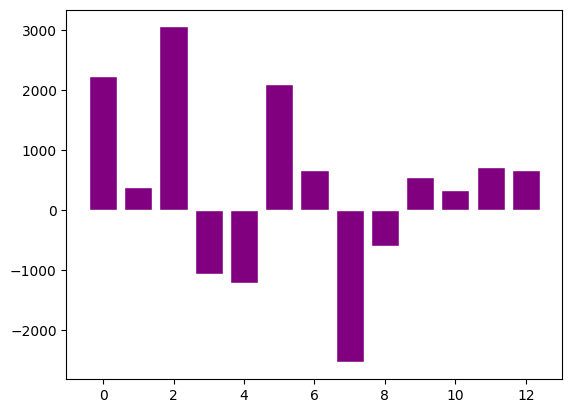

In [1104]:
# get importance
importance = linreg_model.params
print(importance)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color = 'purple', edgecolor = 'white')
plt.show()

So that the mtop 3 features that impacts 'label' column are:
- temp : coefficients of 3060.417
- weathersit_Lightsnow: coefficients of -2544.739
- yr_2019: coefficients of 2101.623

# Residual Analysis

In [1105]:
y_train_pred = linreg_model.predict(X_train_sm)

The mean of residuals is approximately at 0 and the distribution is similar to a normal distribution. 

Text(0.5, 9.444444444444438, 'residuals')

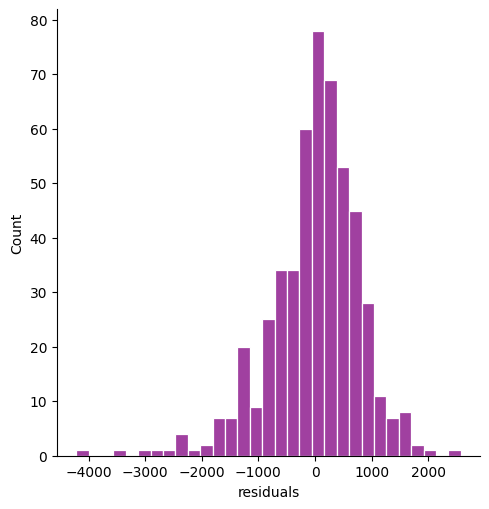

In [1106]:
residuals = y_train - y_train_pred
sns.displot(residuals, color = 'purple', edgecolor = 'white')
plt.xlabel('residuals')

Plotting the residuals against the predictions, the variance of residuals through time is quite constant in the chart below.

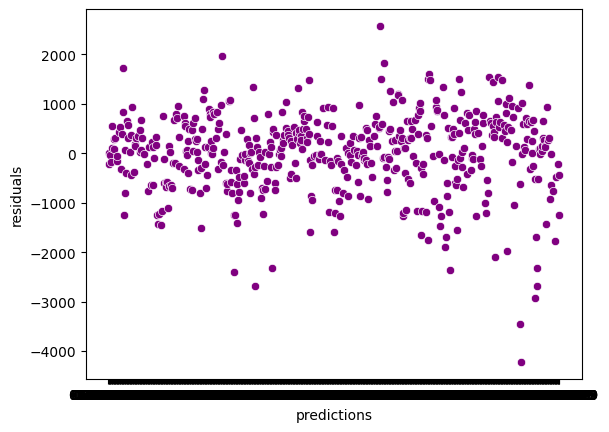

In [1107]:
sns.scatterplot(x=raw['dteday'], y = residuals, color = 'purple', edgecolor = 'white')
plt.ylabel('residuals')
plt.xlabel('predictions')
plt.show()

There are no visible patterns or trends in the below chart, so that the error terms is independent.

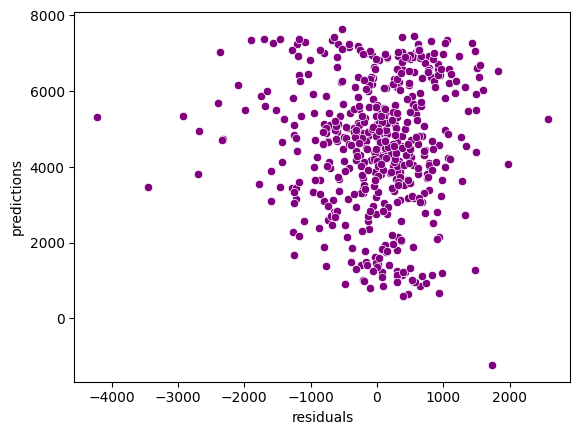

In [1108]:
sns.scatterplot(x=residuals, y = y_train_pred, color = 'purple', edgecolor = 'white')
plt.xlabel('residuals')
plt.ylabel('predictions')
plt.show()

# Predictions on the test set

The only column needs scaling are left is 'windspeed':

In [1109]:
# Take the columns that are left in train dataset
num_vars = ['temp', 'hum', 'windspeed']
# Transform the test set
X_test[num_vars] = scaler.transform(X_test[num_vars])

Let's predict on the test set:

In [1110]:
# Add constant to train dataset
X_test_sm = sm.add_constant(X_test)
# Take columns from final train set to test set
cols = X_train_sm.columns
X_test_sm = X_test_sm[cols]

Test set now have the same 13 final columns as train set:

In [1111]:
# Predict the test set
y_test_pred = linreg_model.predict(X_test_sm)

# Final R square

R squared on train set:

In [1112]:
from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_train_pred)
r2_train

0.824218025635649

Adjusted R squared on train set:

In [1113]:
n = int(len(X_train_sm))
p = int(len(X_train_sm.columns))

adj_r2_train = 1-(((1-(r2_train)**2)*(n-1))/(n-p-1))
adj_r2_train

0.6709477473424366

R squared on test set:

In [1114]:
from sklearn.metrics import r2_score
r2_test = r2_score(y_test, y_test_pred)
r2_test

0.8394851499426481

Adjusted R squared on test set:

In [1115]:
n = int(len(X_test_sm))
p = int(len(X_test_sm.columns))

adj_r2_test = 1-(((1-(r2_test)**2)*(n-1))/(n-p-1))
adj_r2_test

0.6860112151238158

So that, the model is perfoming well on both train and test set.